# AI in Medicine I - Practical 2: Brain Tissue Segmentation

Segmentation of different tissues from MRI scans of the brain is an important step for further downstream applications such as disease prediction, classification or brain age estimation.

The goal of the coursework is to implement classical and deep learning approaches for segmentation of different tissue types in MRI scans of the brain, i.e., background, cerebrospinal fluid (CSF), white matter (WM), and gray matter (GM). We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final segmentation accuracy.
Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

**Make sure to select the correct runtime when working in Google Colab (GPU)**

## Downloading the Data

In [2]:
! wget -q --show-progress https://www.dropbox.com/s/w9njau9t6rrheel/brainage-data.zip
! unzip -qq -o brainage-data.zip
! wget -q --show-progress https://www.dropbox.com/s/f5mt8p9pkszff3x/brainage-testdata.zip
! unzip -qq -o brainage-testdata.zip


zsh:1: command not found: wget
unzip:  cannot find or open brainage-data.zip, brainage-data.zip.zip or brainage-data.zip.ZIP.
zsh:1: command not found: wget
unzip:  cannot find or open brainage-testdata.zip, brainage-testdata.zip.zip or brainage-testdata.zip.ZIP.


## Imports

In [3]:
import os
import glob
import random
from argparse import Namespace
from functools import partial
from multiprocessing import Pool
from numbers import Number
from typing import Any, Dict
from typing import List, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False


def mean_absolute_error(preds: Tensor, targets: Tensor) -> float:
    """Compute the mean absolute error between predictions and targets"""
    return (preds.view(-1) - targets.view(-1)).abs().mean().item()


class TensorboardLogger(SummaryWriter):
    def __init__(
        self,
        log_dir: str = None,
        config: Namespace = None,
        enabled: bool = True,
        comment: str = '',
        purge_step: int = None,
        max_queue: int = 10,
        flush_secs: int = 120,
        filename_suffix: str = ''
    ):
        self.enabled = enabled
        if self.enabled:
            super().__init__(
                log_dir=log_dir,
                comment=comment,
                purge_step=purge_step,
                max_queue=max_queue,
                flush_secs=flush_secs,
                filename_suffix=filename_suffix
            )
        else:
            return

        # Add config
        if config is not None:
            self.add_hparams(
                {k: v for k, v in vars(config).items() if isinstance(
                    v, (int, float, str, bool, torch.Tensor))},
                {}
            )

    def log(self, data: Dict[str, Any], step: int) -> None:
        """Log each entry in data as its corresponding data type"""
        if self.enabled:
            for k, v in data.items():
                # Scalars
                if isinstance(v, Number):
                    self.add_scalar(k, v, step)

                # Images
                elif (isinstance(v, np.ndarray) or isinstance(v, torch.Tensor)) and len(v.shape) >= 3:
                    if len(v.shape) == 3:
                        self.add_image(k, v, step)
                    elif len(v.shape) == 4:
                        self.add_images(k, v, step)
                    else:
                        raise ValueError(f'Unsupported image shape: {v.shape}')

                # Matplotlib figures
                elif isinstance(v, plt.Figure):
                    self.add_figure(k, v, step)

                else:
                    raise ValueError(f'Unsupported data type: {type(v)}')


def load_nii(path: str, dtype: str = 'float32') -> np.ndarray:
    """Load an MRI scan from disk and convert it to a given datatype

    :param path: Path to file
    :param dtype: Target dtype
    :return img: Loaded image. Shape (H, W, D)
    """
    return nib.load(path).get_fdata().astype(np.dtype(dtype))


def load_segmentations(paths: str):
    """Load all segmentations and associated subject_ids"""
    filenames, segmentations = [], []
    for im in tqdm(paths):
        id = im.split('_brain_')[0].split('/')[-1].split('-')[1].split('_')[0]
        segmentations.append(load_nii(im))
        filenames.append(id)
    return filenames, np.array(segmentations)


def plot_segmentations(im: np.ndarray, seg: np.ndarray, i: int = 65, title: str = None):
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))

    col = 2
    ax[0, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[..., i], k=3),
                 alpha=0.5 * (np.rot90(seg[..., i] > 0, k=3)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].set_title('Axial')

    k = 1
    col = 0
    ax[0, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[i, ...], k=k),
                 alpha=0.5 * (np.rot90(seg[i, ...] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].set_title('Sagittal')

    col = 1
    ax[0, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[:, i, :], k=k),
                 alpha=0.5 * (np.rot90(seg[:, i, :] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].set_title('Coronal')

    if title is not None:
        # plt.set_title(title)
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()



%load_ext tensorboard
%load_ext autoreload
%autoreload 2

## Getting started and familiarise ourselves with the data

We provide the data of 652 subjects from which we use 522 for training, 65 for validation, and the rest of 65 for testing your final model.

## Imaging data
Let's check out the imaging data that is available for each subject.

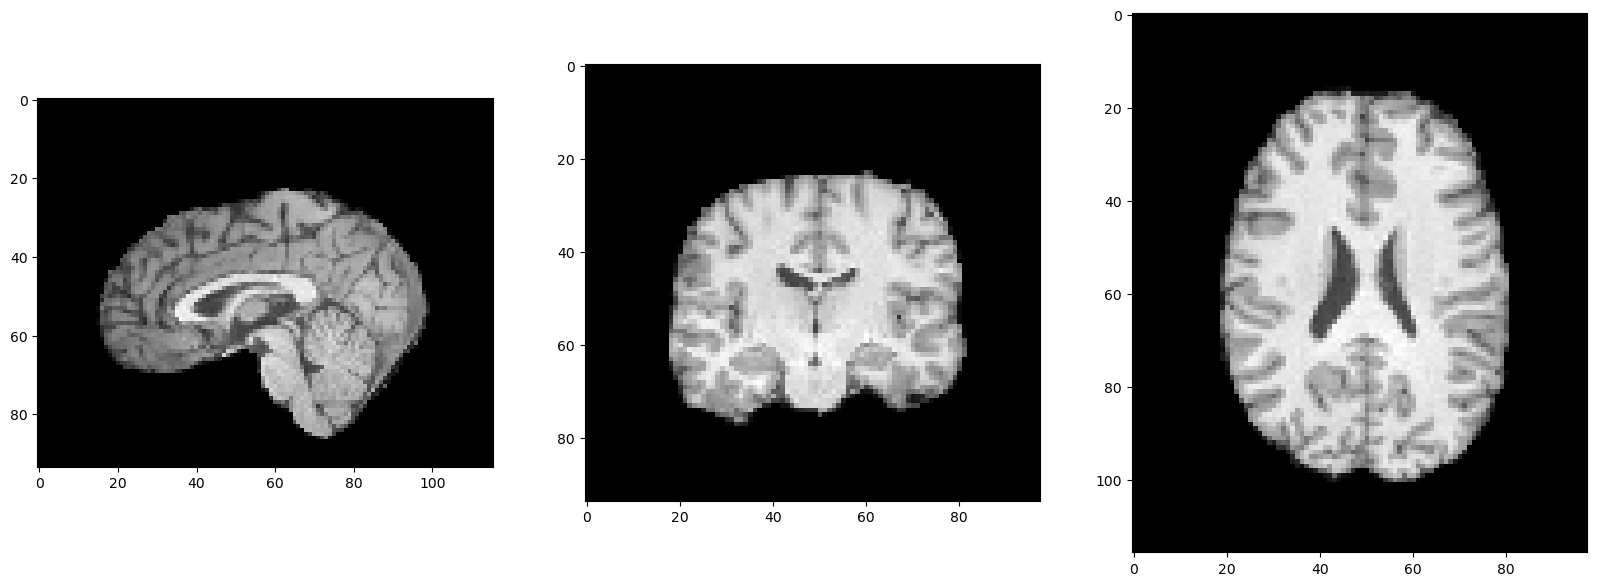

In [4]:
file = './data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz'

image = nib.load(file).get_fdata()

f, axarr = plt.subplots(1, 3, figsize=(20, 10))
H, W, D = image.shape
axarr[0].imshow(np.flip(image[H // 2, :, :].T, axis=0), cmap='gray')
axarr[1].imshow(np.flip(image[:, W // 2, :].T, axis=0), cmap='gray')
axarr[2].imshow(image[:, :, D // 2].T, cmap='gray')
plt.show()

In [5]:
paths = sorted(glob.glob('data/brain_age/segs_refs/*'))
filenames, segmentations = load_segmentations(paths)

100%|████████████████████████████████████████████████████████████| 652/652 [00:02<00:00, 280.97it/s]


In [6]:
np.random.seed(10282022)

all_keys = np.asarray(range(len(filenames)))
ratio_test = int(0.1 * len(all_keys))  # 10% val; 10% test
val_keys = np.random.choice(all_keys, 2 * ratio_test, replace=False)
test_keys = np.random.choice(val_keys, ratio_test, replace=False)

train_files, val_files, test_files = [], [], []
segmentations_train, segmentations_val, segmentations_test =  [],  [], []
for scan_id in tqdm(all_keys):
  scan = f'data/brain_age/images/sub-{filenames[scan_id]}_T1w_unbiased.nii.gz'
  seg = segmentations[scan_id]
  if scan_id in test_keys:
      test_files.append(scan)
      segmentations_test.append(seg)
  elif scan_id in val_keys:
      val_files.append(scan)
      segmentations_val.append(seg)
  else:
      train_files.append(scan)
      segmentations_train.append(seg)
print(f'{len(train_files)} train files')
print(f'{len(val_files)} val files')
print(f'{len(test_files)} test files')

100%|█████████████████████████████████████████████████████████| 652/652 [00:00<00:00, 263431.87it/s]

522 train files
65 val files
65 test files


Let's visualize one validations sample

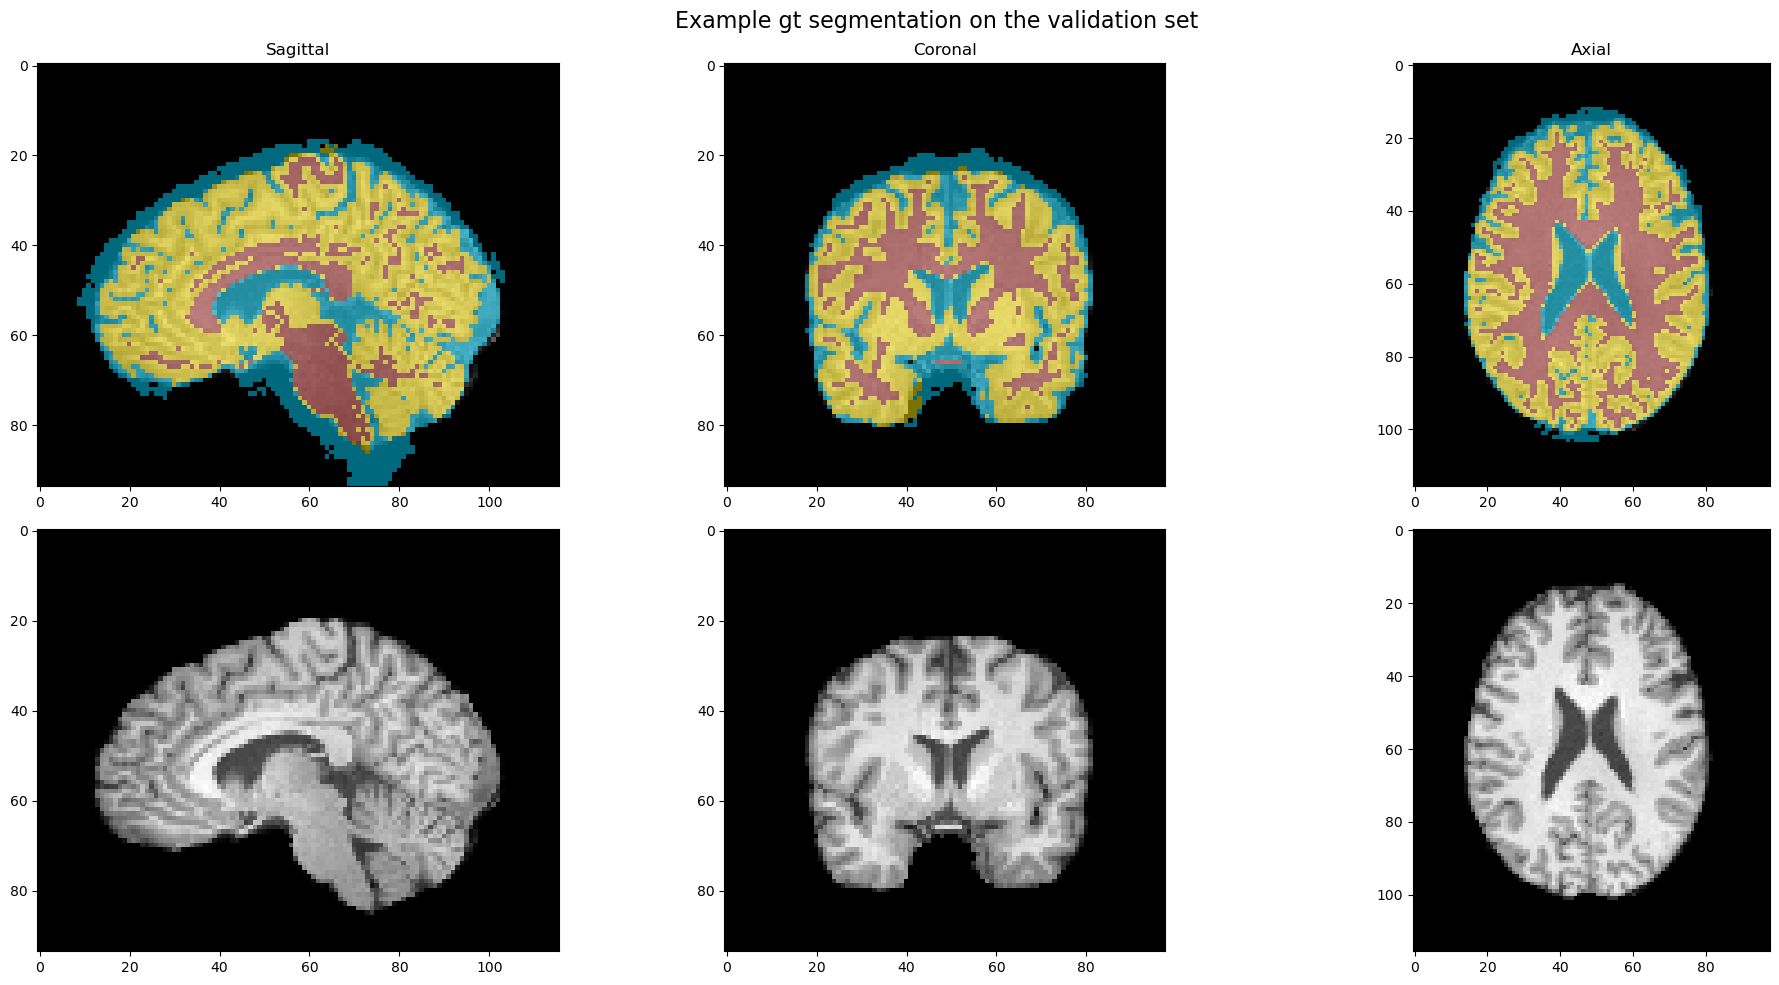

In [7]:
im = load_nii(val_files[0])
plot_segmentations(im, segmentations_val[0], i=47, title='Example gt segmentation on the validation set')

# Task 1: Evaluation and Visualization

**Q1a**. We first have to define how good our predicted segmentations are. Implement the evaluation functions below.

In [8]:
np.unique(np.array(segmentations_test)[15])

array([0., 1., 2., 3.], dtype=float32)

In [9]:
# The Dice similarity coefficient is widely used for evaluating image segmentation alogrithms.
# Implement a method that computes the patient-wise Dice score, precision, and recall (mean and std) for the test dataset.
# Hint: Don't forget that there are multiple classes.
# --------------------------- ADD YOUR CODE HERE ------------------------------

def dice_coefficient_precision_recall(predictions, gt): 
  predictions = np.array(predictions)
  gt = np.array(gt)

  unique_classes = np.unique(gt)
  num_classes = len(unique_classes)
  num_patients = predictions.shape[0]

  dice = np.zeros((num_classes, num_patients))
  precision = np.zeros((num_classes, num_patients))
  recall = np.zeros((num_classes, num_patients))

  for patient_idx in range(num_patients):
      for i, cls in enumerate(unique_classes):
        pred = predictions[patient_idx, :, :, :]
        ground_truth = gt[patient_idx, :, :, :]

        true_positive = np.sum(np.logical_and(pred == cls, ground_truth == cls))
        false_positive = np.sum(np.logical_and(pred == cls, ground_truth != cls))
        false_negative = np.sum(np.logical_and(pred != cls, ground_truth == cls))

        # Calculate Dice, precision, and recall for the current class and patient
        dice[i, patient_idx] = (2.0 * true_positive) / (2.0 * true_positive + false_positive + false_negative + 1e-5)
        precision[i, patient_idx] = true_positive / (true_positive + false_positive + 1e-5)
        recall[i, patient_idx] = true_positive / (true_positive + false_negative + 1e-5)

  return dice, precision, recall
def Dice(predictions, gt):

  dice, _, _ = dice_coefficient_precision_recall(predictions, gt)
  mean, std = dice.mean(axis=0), dice.std(axis=0)
  return mean, std

def precision(predictions, gt):

  _, precision, _ = dice_coefficient_precision_recall(predictions, gt)
  mean, std = precision.mean(axis=0) , precision.std(axis=0)
  return mean, std

def recall(predictions, gt):

  _, _, recall = dice_coefficient_precision_recall(predictions, gt)
  mean, std = recall.mean(axis=0), recall.std(axis=0)
  return mean, std

# ----------------------------------- END -------------------------------------

**Q1b**. Next, we want to visualize the best- and worst-performing samples in the test set. Implement a function that evaluates the entire test dataset and outputs the index of the best and worst performing samples according to the Dice coefficient.

In [10]:
# You may change the functions below as you see fit

# --------------------------- ADD YOUR CODE HERE ------------------------------
def get_best_and_worst_ids(predictions):
    best_ids, worst_ids = -1, -1

    # TODO: implement
    dice_scores = Dice(predictions, segmentations_test)[0]

    # Find the index of the best and worst Dice scores
    best_ids = np.argmax(dice_scores)
    worst_ids = np.argmin(dice_scores)
    # print(dice_scores.shape)
    best_performance, worst_performance = dice_scores[best_ids], dice_scores[worst_ids]
    return {
        'best_id': best_ids,
        'best_performance': best_performance,
        'worst_id': worst_ids,
        'worst_performance': worst_performance
    }

def visualize_best_and_worst_samples(predictions, i_best=47, i_worst=47):
    return_dict = get_best_and_worst_ids(predictions)

    best_id = return_dict['best_id']
    plot_segmentations(load_nii(test_files[best_id]), predictions[best_id], i=i_best,
                       title=f'Best prediction on the test set (Dice: {return_dict["best_performance"]:.2f})')

    worst_id = return_dict['worst_id']
    plot_segmentations(load_nii(test_files[worst_id]), predictions[worst_id], i=i_worst,
                       title=f'Worst prediction on the test set (Dice: {return_dict["worst_performance"]:.2f})')
# ----------------------------------- END -------------------------------------

**Q1c**. Given a set of predictions for a number of models, create a summary figure of your choice (e.g. table, bar plot) which visualizes all of the metric values. Visualize multiple metrics (Dice coefficient, precision, and recall), each computed for every tissue type. A sample dictionary is provided below.

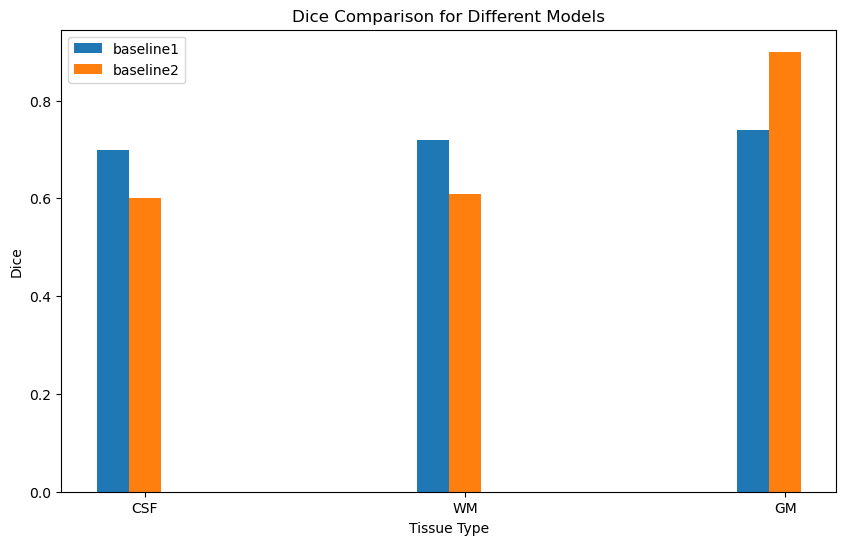

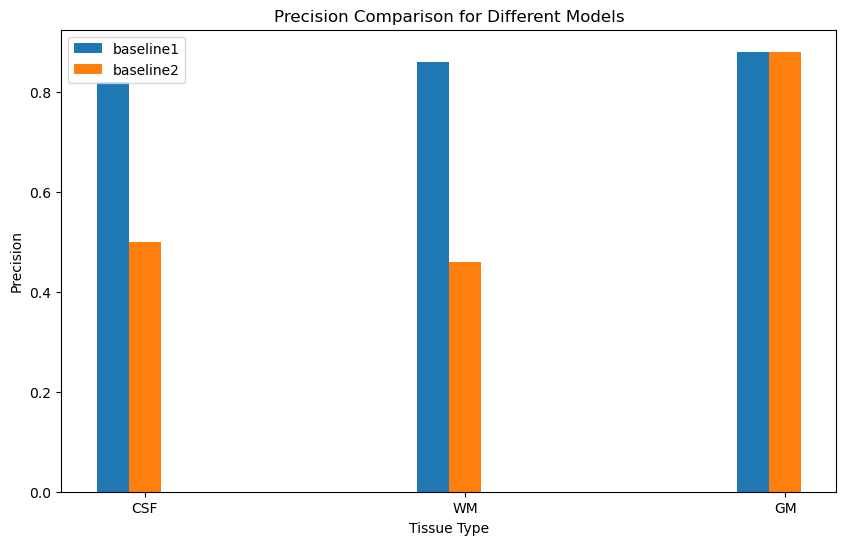

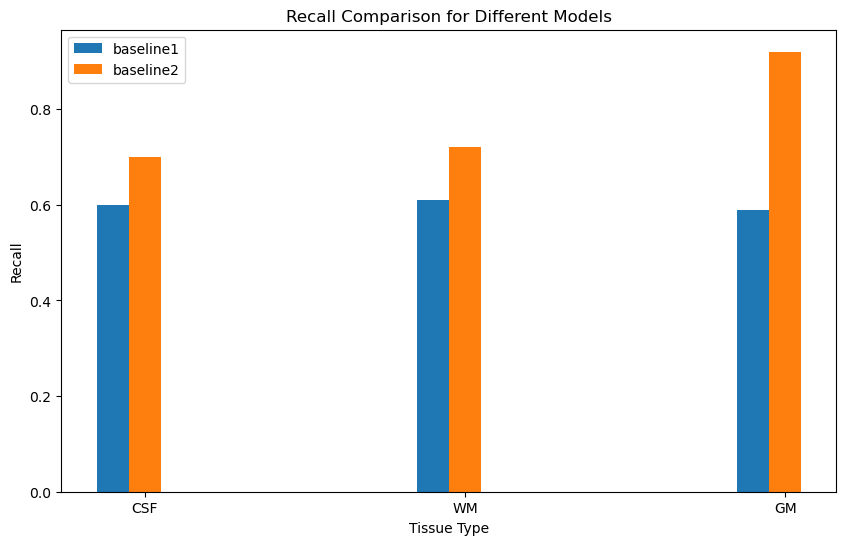

In [11]:
# --------------------------- ADD YOUR CODE HERE ------------------------------

def get_results_dictionary(predictions):
    results_dict = {}
    tissues = ['CSF', 'WM', 'GM']

    dice, precision, recall = dice_coefficient_precision_recall(predictions, segmentations_test)

    dice_tissue_mean = dice.mean(axis=1)
    precision_tissue_mean = precision.mean(axis=1)
    recall_tissue_mean = recall.mean(axis=1)

    for i, tissue in enumerate(tissues): 
        
        dict_ = {'dice': '-1', 'precision': '-1', 'recall': '-1'}

        dict_['dice'] = str(dice_tissue_mean[i + 1])
        dict_['precision'] = str(precision_tissue_mean[i + 1])
        dict_['recall'] = str(recall_tissue_mean[i + 1])
        
        results_dict[tissue] = dict_

    return results_dict

def plot_results_summary(results_dict: Dict[str, Dict[str, Dict[str, str]]]) -> None:
    
    tissues = list(next(iter(results_dict.values())).keys())
    metrics = ['dice', 'precision', 'recall']
    models = list(results_dict.keys())

    bar_width = 0.1
    index = np.arange(len(tissues))

    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for i, model in enumerate(models):
            values = [float(results_dict[model][tissue][metric]) for tissue in tissues]
            plt.bar(index + i * bar_width, values, bar_width, label=model)

        plt.xlabel('Tissue Type')
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} Comparison for Different Models')
        plt.xticks(index + (len(models) / 2) * bar_width, tissues)
        plt.legend()

        plt.show()
# ----------------------------------- END -------------------------------------

sample_results = {
    'baseline1': {
        'CSF': {'dice': '0.7', 'precision': '0.82', 'recall': '0.6'},
        'WM': {'dice': '0.72', 'precision': '0.86', 'recall': '0.61'},
        'GM': {'dice': '0.74', 'precision': '0.88', 'recall': '0.59'},
    },
    'baseline2': {
        'CSF': {'dice': '0.6', 'precision': '0.5', 'recall': '0.7'},
        'WM': {'dice': '0.61', 'precision': '0.46', 'recall': '0.72'},
        'GM': {'dice': '0.9', 'precision': '0.88', 'recall': '0.92'},
    }
}
plot_results_summary(sample_results)

# Task 2: Unsupervised segmentation

The first approach aims to segment the brain tissues, including grey matter (GM), white matter (WM), cerebrospinal fluid (CSF), and background using unsupervised classical machine learning techniques.

Different unsupervised techniques to leverage the different intensity profile of the tissues should be explored.

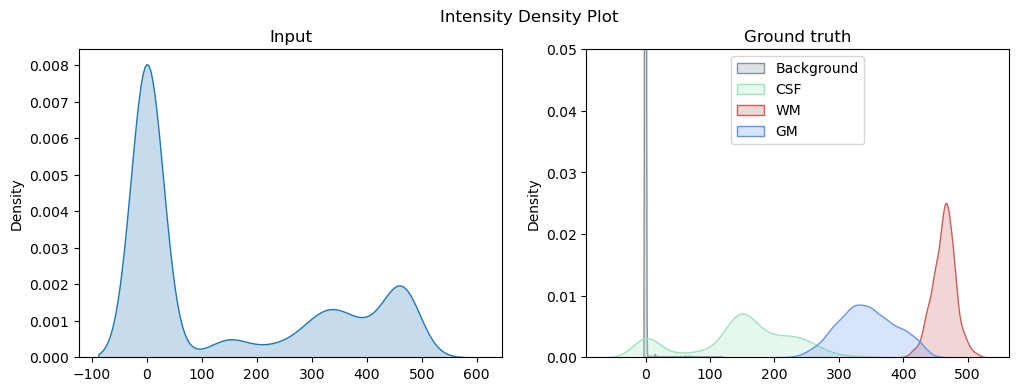

In [12]:
slice_id = 0
im_ = load_nii(val_files[slice_id])[:,:,47].flatten()
seg_ = segmentations_val[slice_id][:,:,47].flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(im_[np.argwhere(seg_ == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Ground truth')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])

## Unsupervised Learning

Here, you should experiment with different *classical* unsupervised machine learning methods, e.g., clustering, density estimation, etc... (at least two different methods). Hint: sklearn has implementations of unsupervised methods

**HINT**: You can predict the different classes of intensities even without any training!

**HINT**: You can evaluate every volume slice-by-slice if the whole volume does not fit in the memory.

#### QUESTION Q2a.
Implement an unsupervised learning method of your choice.
Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 1.

In [13]:
# Unsupervised method 1
# --------------------------- ADD YOUR CODE HERE ------------------------------
'''
========== Report ==========
Image Loading and Reshaping:
The code loads medical images using load_nii and reshapes them to a flat 1D array.
KMeans Clustering:
Utilizes the KMeans clustering algorithm from scikit-learn to cluster the voxel intensities into four clusters.
Finding Right Cluster Indexes:
Generates combinations of four values (indexes) and applies them to the clustered labels, selecting the 
combination that maximizes the Dice similarity coefficient with the ground truth segmentation.
Performance Evaluation:
Computes the Dice score by comparing the predicted segmentation with the ground truth segmentation.
'''

from sklearn.cluster import KMeans

H, W, D = load_nii(test_files[0]).shape
pred_seg_1 = np.array([], dtype=np.int64).reshape(0, H, W, D)

for x in range(len(test_files)):
    # print(f'========== Image {x+1} ==========')
    
    # image loading and reshaping
    im_ = load_nii(test_files[x])
    im_flat = im_.reshape(-1, 1)

    # clustering
    clusters = 4
    kmeans = KMeans(n_clusters=clusters, random_state=42, n_init='auto').fit(im_flat)
    im_flat_labels = kmeans.labels_
    im_labels = im_flat_labels.reshape(1, H, W, D)

    # find right cluster indexes
    im_cluster = np.array([], dtype=np.int64).reshape(0, H, W, D)
    
    values = np.arange(4)
    i, j, k, l = np.meshgrid(values, values, values, values)
    i_flat, j_flat, k_flat, l_flat = i.flatten(), j.flatten(), k.flatten(), l.flatten()

    comparison_ = np.array([])
    
    count = 1
    for i_val, j_val, k_val, l_val in zip(i_flat, j_flat, k_flat, l_flat):
        if i_val != j_val and i_val != k_val and i_val != l_val and j_val != k_val and j_val != l_val and k_val != l_val: 
            # print(f"{count} - - - i: {i_val}, j: {j_val}, k: {k_val}, l: {l_val}")
            count += 1

            copy_im_labels = im_labels.copy()
            
            vals = np.array([i_val, j_val, k_val, l_val])
            for m in range(4):
                indices = np.argwhere(im_labels == m)
                copy_im_labels[indices[:, 0], indices[:, 1], indices[:, 2], indices[:, 3]] = vals[m]
            
            im_cluster = np.vstack((im_cluster, copy_im_labels))
            
            comparison = np.equal(copy_im_labels.reshape(H, W, D), segmentations_test[x])
            comparison_result = comparison.astype(int)
            comparison_sum = np.sum(comparison_result)
            comparison_ = np.append(comparison_, comparison_sum)
                
    best_id = np.argmax(comparison_)
    pred_seg_1 = np.vstack((pred_seg_1, im_cluster[best_id].reshape(1, H, W, D)))
    
    print(pred_seg_1.shape)
# ----------------------------------- END -------------------------------------

(1, 98, 116, 94)
(2, 98, 116, 94)
(3, 98, 116, 94)
(4, 98, 116, 94)
(5, 98, 116, 94)
(6, 98, 116, 94)
(7, 98, 116, 94)
(8, 98, 116, 94)
(9, 98, 116, 94)
(10, 98, 116, 94)
(11, 98, 116, 94)
(12, 98, 116, 94)
(13, 98, 116, 94)
(14, 98, 116, 94)
(15, 98, 116, 94)
(16, 98, 116, 94)
(17, 98, 116, 94)
(18, 98, 116, 94)
(19, 98, 116, 94)
(20, 98, 116, 94)
(21, 98, 116, 94)
(22, 98, 116, 94)
(23, 98, 116, 94)
(24, 98, 116, 94)
(25, 98, 116, 94)
(26, 98, 116, 94)
(27, 98, 116, 94)
(28, 98, 116, 94)
(29, 98, 116, 94)
(30, 98, 116, 94)
(31, 98, 116, 94)
(32, 98, 116, 94)
(33, 98, 116, 94)
(34, 98, 116, 94)
(35, 98, 116, 94)
(36, 98, 116, 94)
(37, 98, 116, 94)
(38, 98, 116, 94)
(39, 98, 116, 94)
(40, 98, 116, 94)
(41, 98, 116, 94)
(42, 98, 116, 94)
(43, 98, 116, 94)
(44, 98, 116, 94)
(45, 98, 116, 94)
(46, 98, 116, 94)
(47, 98, 116, 94)
(48, 98, 116, 94)
(49, 98, 116, 94)
(50, 98, 116, 94)
(51, 98, 116, 94)
(52, 98, 116, 94)
(53, 98, 116, 94)
(54, 98, 116, 94)
(55, 98, 116, 94)
(56, 98, 116, 94)
(

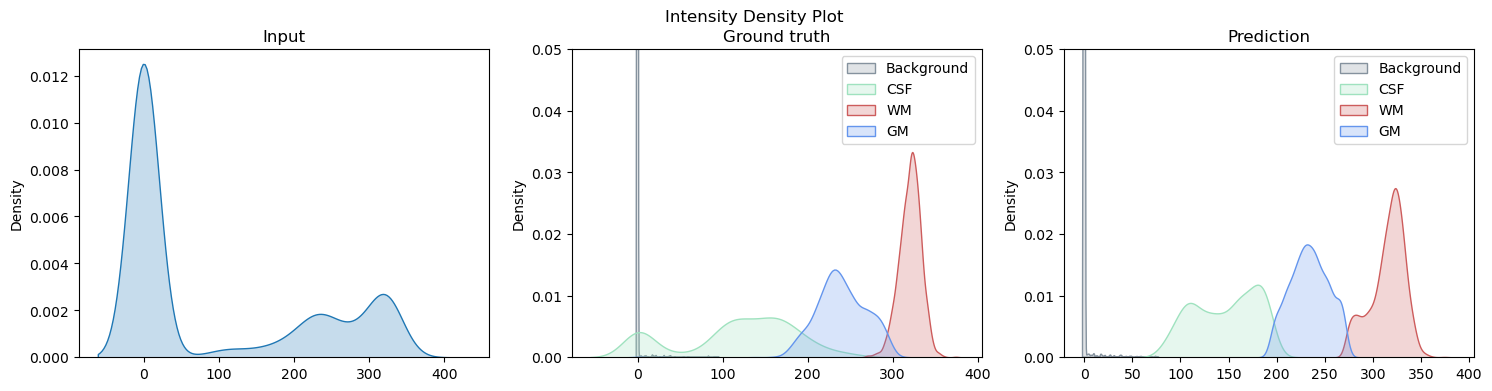

In [16]:
# Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------
def densityEstimations(pred_seg_):
    volume = 0
    slice_id = 47
    im_ = load_nii(test_files[volume])[:,:,slice_id].flatten()
    pred_ = pred_seg_[volume][:, :, slice_id].flatten()
    seg_ = segmentations_test[volume][:,:,slice_id].flatten()

    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
    fig.suptitle('Intensity Density Plot')

    sns.kdeplot(im_, ax=axes[0], fill=True)
    axes[0].set_title('Input')

    sns.kdeplot(im_[np.argwhere(seg_ == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
    sns.kdeplot(im_[np.argwhere(seg_ == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
    sns.kdeplot(im_[np.argwhere(seg_ == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
    sns.kdeplot(im_[np.argwhere(seg_ == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
    axes[1].set_ylim(0, 0.05)
    axes[1].set_title('Ground truth')
    axes[1].legend(loc='upper right', labels=['Background', 'CSF', 'WM', 'GM'])

    sns.kdeplot(im_[np.argwhere(pred_ == 0)][:, 0], ax=axes[2], fill=True, color='#85929E', label='Background', legend=True)
    sns.kdeplot(im_[np.argwhere(pred_ == 1)][:, 0], ax=axes[2], fill=True, color='#9FE2BF', label='CSF', legend=True)
    sns.kdeplot(im_[np.argwhere(pred_ == 3)][:, 0], ax=axes[2], fill=True, color='#CD5C5C', label='WM', legend=True)
    sns.kdeplot(im_[np.argwhere(pred_ == 2)][:, 0], ax=axes[2], fill=True, color='#6495ED', label='GM', legend=True)
    axes[2].set_ylim(0, 0.05)
    axes[2].set_title('Prediction')
    axes[2].legend(loc='upper right', labels=['Background', 'CSF', 'WM', 'GM'])
densityEstimations(pred_seg_1)
# ----------------------------------- END -------------------------------------

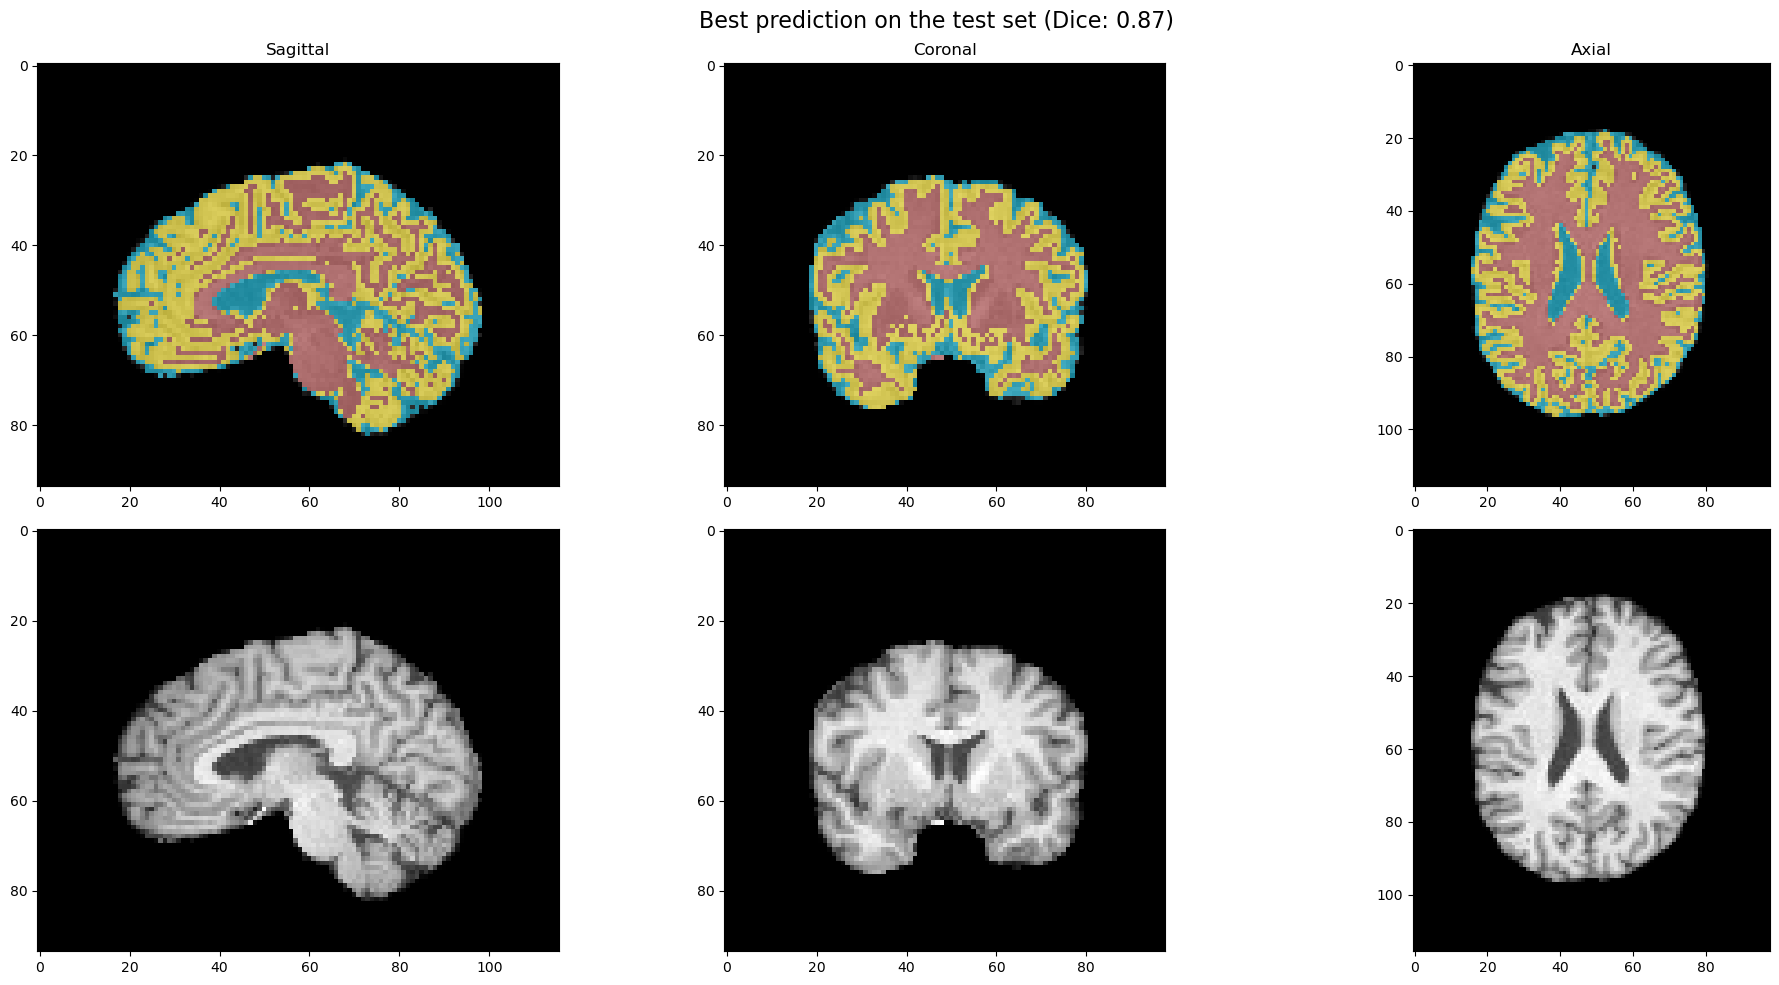

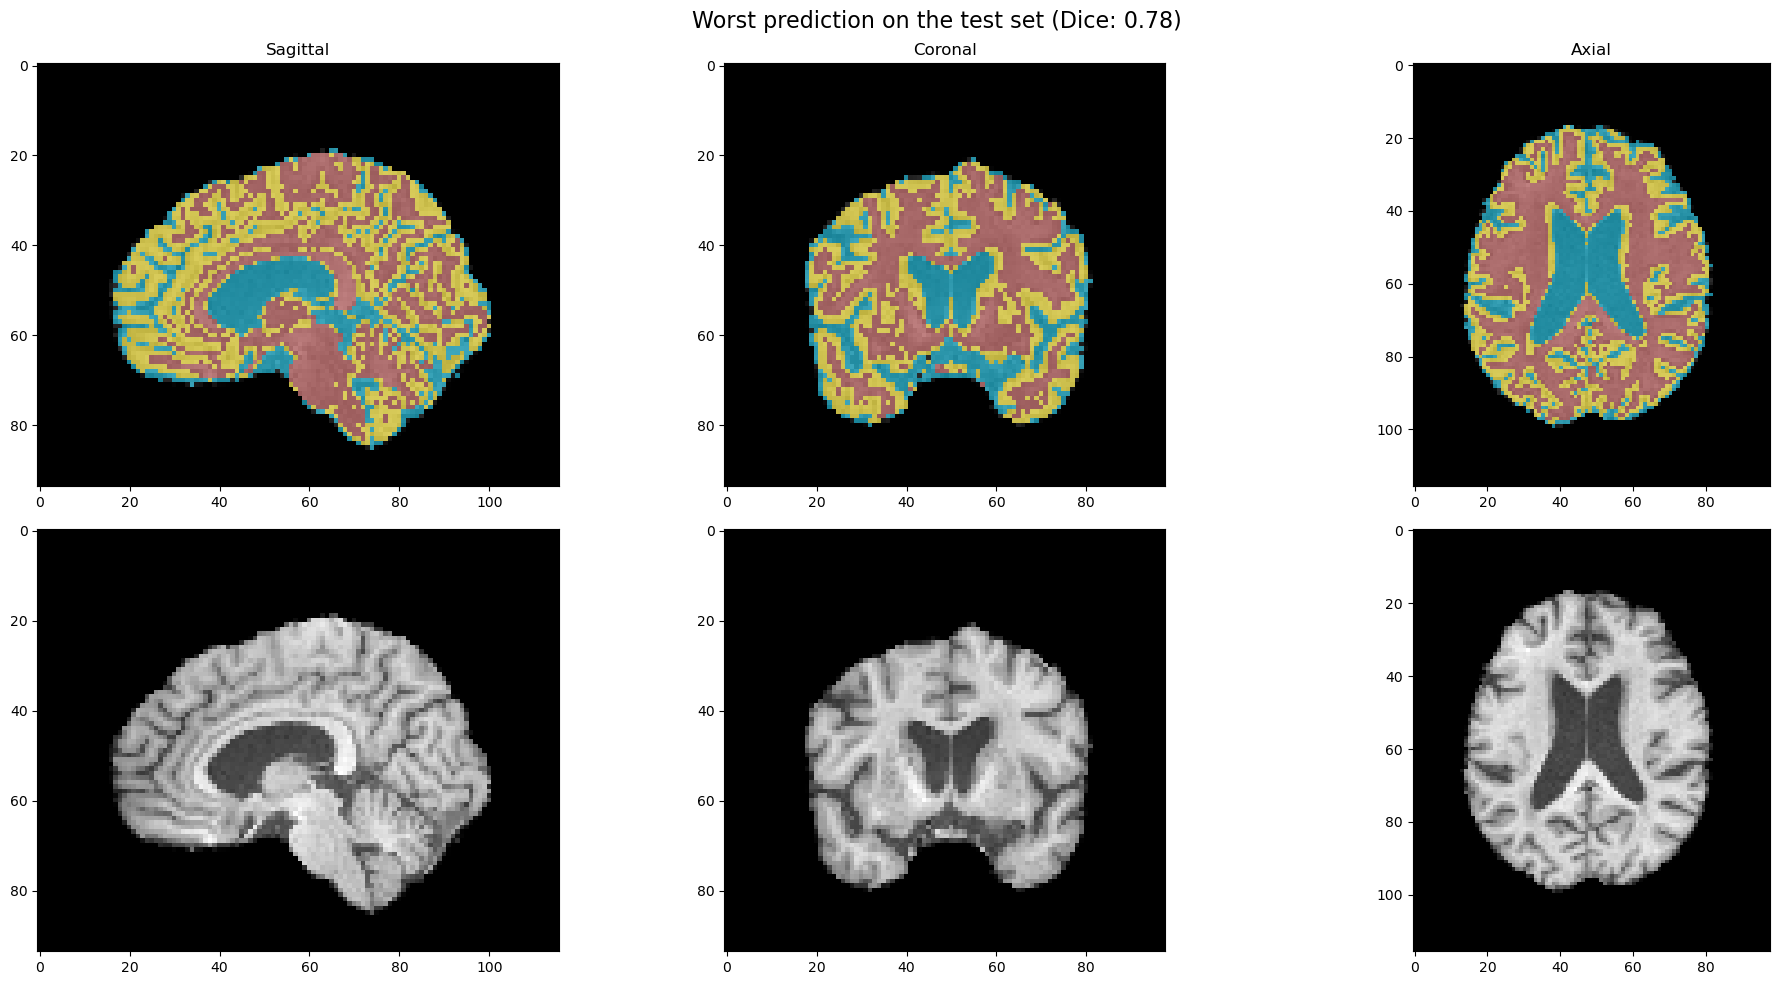

In [17]:
# Visualize the best and worst predictions on the test set for method 1
visualize_best_and_worst_samples(pred_seg_1)

#### QUESTION Q2b.
Implement a second unsupervised learning method of your choice.
Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 2.

In [18]:
# Unsupervised method 2
# --------------------------- ADD YOUR CODE HERE ------------------------------

# 4 components which are grey matter (GM), white matter (WM), cerebrospinal fluid (CSF), and background 


def image_data_load(image_files):
    original_images = []
    flatted_images = []
    for i in range(len(image_files)):
        image = load_nii(image_files[i])   # image_shape 98,116,94
        original_images.append(image)
        image = image.reshape(-1,1)
        flatted_images.append(image)
    return original_images, flatted_images

def reconstruct_images(labels, original_shape):
    return labels.reshape(original_shape)

train_images, flatted_train_images = image_data_load(train_files)
test_images, flatted_test_images = image_data_load(test_files)

In [19]:
from sklearn.mixture import GaussianMixture as GMM

gmm_models = [] 

def model_training(train_files): #Gaussian Mixture Model
    
    for i in range(len(train_files)):
        gmm_model = GMM(n_components=4).fit(flatted_train_images[i])
        gmm_models.append(gmm_model)  # Store the trained model in the list

        # Print the weights of the components
        print(f"Weights for GMM model {i}: {gmm_model.weights_}")

        print(f"Trained GMM for image {i}")
    
    print("finish training")
    return gmm_models

model = model_training(train_files)

Weights for GMM model 0: [0.82934461 0.07807395 0.03617647 0.05640497]
Trained GMM for image 0
Weights for GMM model 1: [0.83277794 0.07996418 0.05392105 0.03333683]
Trained GMM for image 1
Weights for GMM model 2: [0.05440299 0.84544422 0.07150119 0.0286516 ]
Trained GMM for image 2
Weights for GMM model 3: [0.81180203 0.05957789 0.0340035  0.09461659]
Trained GMM for image 3
Weights for GMM model 4: [0.8314668  0.06960429 0.05932598 0.03960293]
Trained GMM for image 4
Weights for GMM model 5: [0.84409658 0.05056876 0.03374959 0.07158507]
Trained GMM for image 5
Weights for GMM model 6: [0.81623452 0.08424342 0.0419119  0.05761016]
Trained GMM for image 6
Weights for GMM model 7: [0.08389236 0.81042711 0.06465298 0.04102755]
Trained GMM for image 7
Weights for GMM model 8: [0.82274014 0.08848609 0.03288993 0.05588384]
Trained GMM for image 8
Weights for GMM model 9: [0.86654157 0.06306288 0.04555002 0.02484553]
Trained GMM for image 9
Weights for GMM model 10: [0.83851266 0.08041437 0

Weights for GMM model 85: [0.82375892 0.06090061 0.03619993 0.07914054]
Trained GMM for image 85
Weights for GMM model 86: [0.06970976 0.80610178 0.07824874 0.04593973]
Trained GMM for image 86
Weights for GMM model 87: [0.81935869 0.0845661  0.04149997 0.05457523]
Trained GMM for image 87
Weights for GMM model 88: [0.82627636 0.07688119 0.05747536 0.03936709]
Trained GMM for image 88
Weights for GMM model 89: [0.81854141 0.05738973 0.08536846 0.0387004 ]
Trained GMM for image 89
Weights for GMM model 90: [0.83165506 0.07231211 0.04370681 0.05232603]
Trained GMM for image 90
Weights for GMM model 91: [0.77691285 0.07742824 0.0565096  0.0891493 ]
Trained GMM for image 91
Weights for GMM model 92: [0.82072428 0.08243282 0.05987289 0.03697001]
Trained GMM for image 92
Weights for GMM model 93: [0.86320884 0.06316476 0.03233315 0.04129325]
Trained GMM for image 93
Weights for GMM model 94: [0.08310177 0.81693963 0.0601955  0.03976311]
Trained GMM for image 94
Weights for GMM model 95: [0.8

Weights for GMM model 169: [0.81747843 0.06006362 0.079632   0.04282595]
Trained GMM for image 169
Weights for GMM model 170: [0.81152053 0.06939308 0.04424513 0.07484125]
Trained GMM for image 170
Weights for GMM model 171: [0.80800808 0.07447812 0.07890147 0.03861234]
Trained GMM for image 171
Weights for GMM model 172: [0.05411909 0.83877306 0.03798649 0.06912136]
Trained GMM for image 172
Weights for GMM model 173: [0.79335092 0.09468456 0.04721975 0.06474477]
Trained GMM for image 173
Weights for GMM model 174: [0.84533564 0.06899224 0.03304698 0.05262513]
Trained GMM for image 174
Weights for GMM model 175: [0.07633365 0.81822243 0.06942318 0.03602074]
Trained GMM for image 175
Weights for GMM model 176: [0.79811778 0.07515675 0.03636445 0.09036102]
Trained GMM for image 176
Weights for GMM model 177: [0.83598011 0.0589847  0.07188374 0.03315145]
Trained GMM for image 177
Weights for GMM model 178: [0.05821766 0.83116934 0.07060582 0.04000718]
Trained GMM for image 178
Weights fo

Weights for GMM model 252: [0.82345725 0.07544561 0.0443564  0.05674074]
Trained GMM for image 252
Weights for GMM model 253: [0.06909315 0.81787424 0.04714529 0.06588732]
Trained GMM for image 253
Weights for GMM model 254: [0.82525805 0.06542611 0.03998638 0.06932946]
Trained GMM for image 254
Weights for GMM model 255: [0.07917721 0.81080905 0.07222238 0.03779136]
Trained GMM for image 255
Weights for GMM model 256: [0.08153647 0.79636184 0.04421341 0.07788828]
Trained GMM for image 256
Weights for GMM model 257: [0.84162638 0.05037912 0.03690594 0.07108856]
Trained GMM for image 257
Weights for GMM model 258: [0.84107398 0.06907074 0.03476409 0.05509118]
Trained GMM for image 258
Weights for GMM model 259: [0.83931838 0.06377178 0.05877548 0.03813437]
Trained GMM for image 259
Weights for GMM model 260: [0.82084444 0.07037896 0.04236927 0.06640732]
Trained GMM for image 260
Weights for GMM model 261: [0.7856137  0.09078067 0.07153611 0.05206952]
Trained GMM for image 261
Weights fo

Weights for GMM model 335: [0.81693092 0.065891   0.07205007 0.045128  ]
Trained GMM for image 335
Weights for GMM model 336: [0.85470281 0.05026965 0.06132701 0.03370052]
Trained GMM for image 336
Weights for GMM model 337: [0.86517131 0.04633306 0.03054943 0.0579462 ]
Trained GMM for image 337
Weights for GMM model 338: [0.84221564 0.05246329 0.04188705 0.06343402]
Trained GMM for image 338
Weights for GMM model 339: [0.06629618 0.82795296 0.03999995 0.06575091]
Trained GMM for image 339
Weights for GMM model 340: [0.82333233 0.06640353 0.04593152 0.06433262]
Trained GMM for image 340
Weights for GMM model 341: [0.85222892 0.05274889 0.03633786 0.05868432]
Trained GMM for image 341
Weights for GMM model 342: [0.81921961 0.06535994 0.07162176 0.04379869]
Trained GMM for image 342
Weights for GMM model 343: [0.84196329 0.05997116 0.04929865 0.0487669 ]
Trained GMM for image 343
Weights for GMM model 344: [0.83865203 0.05523121 0.04750842 0.05860835]
Trained GMM for image 344
Weights fo

Weights for GMM model 418: [0.82323611 0.04356934 0.08846611 0.04472844]
Trained GMM for image 418
Weights for GMM model 419: [0.82954525 0.06349611 0.04782123 0.05913742]
Trained GMM for image 419
Weights for GMM model 420: [0.78016668 0.07129324 0.06264677 0.0858933 ]
Trained GMM for image 420
Weights for GMM model 421: [0.82069011 0.06010279 0.05211049 0.06709661]
Trained GMM for image 421
Weights for GMM model 422: [0.07039914 0.82953349 0.04224523 0.05782215]
Trained GMM for image 422
Weights for GMM model 423: [0.81604923 0.06143752 0.06210983 0.06040342]
Trained GMM for image 423
Weights for GMM model 424: [0.86783161 0.05129857 0.03901867 0.04185115]
Trained GMM for image 424
Weights for GMM model 425: [0.82356299 0.05603423 0.06490072 0.05550206]
Trained GMM for image 425
Weights for GMM model 426: [0.8564924  0.05237321 0.03538059 0.0557538 ]
Trained GMM for image 426
Weights for GMM model 427: [0.80507708 0.06296173 0.05757788 0.07438331]
Trained GMM for image 427
Weights fo

Weights for GMM model 501: [0.82207806 0.06064681 0.05608776 0.06118736]
Trained GMM for image 501
Weights for GMM model 502: [0.04309373 0.84717919 0.05201021 0.05771686]
Trained GMM for image 502
Weights for GMM model 503: [0.82820433 0.05904485 0.06103035 0.05172047]
Trained GMM for image 503
Weights for GMM model 504: [0.81900847 0.06165415 0.0532862  0.06605118]
Trained GMM for image 504
Weights for GMM model 505: [0.85502777 0.0466297  0.0400336  0.05830893]
Trained GMM for image 505
Weights for GMM model 506: [0.82248793 0.05911903 0.0543181  0.06407494]
Trained GMM for image 506
Weights for GMM model 507: [0.82995553 0.06563178 0.04950159 0.0549111 ]
Trained GMM for image 507
Weights for GMM model 508: [0.84349016 0.053577   0.04082773 0.0621051 ]
Trained GMM for image 508
Weights for GMM model 509: [0.83649218 0.0522436  0.0472063  0.06405792]
Trained GMM for image 509
Weights for GMM model 510: [0.83953868 0.0586556  0.04640964 0.05539608]
Trained GMM for image 510
Weights fo

In [20]:
original_shape = load_nii(train_files[0]).shape # image_shape 98,116,94

def models_prediction(image_files, model, images):
    segmented_image = []
    for i in range(len(images)):
        gmm_labels = model.predict(image_files[i])
        segmented_image.append(reconstruct_images(gmm_labels, original_shape))
    return segmented_image

count = 0
best_segmented_images = 0
for i in range(len(train_files)):
    segmented_image = models_prediction(flatted_test_images, gmm_models[i], test_images)
    results = get_best_and_worst_ids(segmented_image)
    print("model : ", i)
    print("best: ", results['best_performance'] , " worst:" , results['worst_performance'])
    print("----------------------------------")
    if (results['best_performance'] + results['worst_performance'] > count):
        count = results['best_performance'] + results['worst_performance']
        best_segmented_images = segmented_image

segmented_test_images = best_segmented_images

pred_seg_2 = segmented_test_images

# ----------------------------------- END -------------------------------------

model :  0
best:  0.514201178208926  worst: 0.28983635353746334
----------------------------------
model :  1
best:  0.7641499285190736  worst: 0.24597780150066653
----------------------------------
model :  2
best:  0.23950500722638005  worst: 0.03014182832789767
----------------------------------
model :  3
best:  0.6883902021208355  worst: 0.2508700352867427
----------------------------------
model :  4
best:  0.7606731794122336  worst: 0.2460513425492293
----------------------------------
model :  5
best:  0.6479086988077789  worst: 0.2513680273011079
----------------------------------
model :  6
best:  0.5336016978854031  worst: 0.2945399368437559
----------------------------------
model :  7
best:  0.3385837785690384  worst: 0.0037091398912936354
----------------------------------
model :  8
best:  0.5046013502863794  worst: 0.3156660043832442
----------------------------------
model :  9
best:  0.7662261295631898  worst: 0.2461606240086799
----------------------------------
mode

model :  82
best:  0.23589188213333154  worst: 0.02943108914395363
----------------------------------
model :  83
best:  0.5280594249544273  worst: 0.300338541040515
----------------------------------
model :  84
best:  0.5197100460878535  worst: 0.3588658505781432
----------------------------------
model :  85
best:  0.4440372034359187  worst: 0.2484973229848254
----------------------------------
model :  86
best:  0.24132678216646494  worst: 0.060066364740551575
----------------------------------
model :  87
best:  0.5045375479164702  worst: 0.28441757773860643
----------------------------------
model :  88
best:  0.7683918924902822  worst: 0.24597151811604562
----------------------------------
model :  89
best:  0.5296599550585617  worst: 0.3991463393344521
----------------------------------
model :  90
best:  0.5174709077626487  worst: 0.37601818688599004
----------------------------------
model :  91
best:  0.5092849505275817  worst: 0.2485675634983282
----------------------------

model :  163
best:  0.5486841544515507  worst: 0.25008923894258717
----------------------------------
model :  164
best:  0.5240960600300699  worst: 0.31475594411438584
----------------------------------
model :  165
best:  0.5112601553255616  worst: 0.31700806775663415
----------------------------------
model :  166
best:  0.2678482691246193  worst: 0.03892836260548943
----------------------------------
model :  167
best:  0.7652682221868421  worst: 0.2459958507939212
----------------------------------
model :  168
best:  0.5032724101449406  worst: 0.28467053633345896
----------------------------------
model :  169
best:  0.48097877936280287  worst: 0.3292562781504511
----------------------------------
model :  170
best:  0.5327444129484484  worst: 0.24873031002361315
----------------------------------
model :  171
best:  0.513017266453033  worst: 0.3830217334006021
----------------------------------
model :  172
best:  0.25578278210542704  worst: 0.007457176096846332
----------------

model :  244
best:  0.1540977712788934  worst: 0.0020377316292774688
----------------------------------
model :  245
best:  0.519173437412433  worst: 0.341315184275386
----------------------------------
model :  246
best:  0.5229397929315078  worst: 0.32127636096558665
----------------------------------
model :  247
best:  0.4791862203115382  worst: 0.27001038566219054
----------------------------------
model :  248
best:  0.5103904916410591  worst: 0.3807959496694698
----------------------------------
model :  249
best:  0.7823794956715096  worst: 0.24730664763091625
----------------------------------
model :  250
best:  0.4988272562712721  worst: 0.3737672803495007
----------------------------------
model :  251
best:  0.5080907954168691  worst: 0.30866984040130746
----------------------------------
model :  252
best:  0.5059768833587892  worst: 0.3009160816563642
----------------------------------
model :  253
best:  0.2652278679126659  worst: 0.038759187265000834
------------------

model :  325
best:  0.4796598705046594  worst: 0.28416837739770545
----------------------------------
model :  326
best:  0.7968343189479822  worst: 0.24963695125120366
----------------------------------
model :  327
best:  0.7840992737698432  worst: 0.24642044177595174
----------------------------------
model :  328
best:  0.5780565339456174  worst: 0.25024343955943057
----------------------------------
model :  329
best:  0.5162784266201664  worst: 0.377329321708179
----------------------------------
model :  330
best:  0.29698829719230985  worst: 0.0062773814031676384
----------------------------------
model :  331
best:  0.8008189559382826  worst: 0.24740247324604062
----------------------------------
model :  332
best:  0.23482524958465095  worst: 0.038931148100778884
----------------------------------
model :  333
best:  0.4322157203768977  worst: 0.24805542780258746
----------------------------------
model :  334
best:  0.514431137852864  worst: 0.36670182960462344
-------------

model :  406
best:  0.5163864376365337  worst: 0.3394943098402895
----------------------------------
model :  407
best:  0.7717226291741476  worst: 0.2462344147779071
----------------------------------
model :  408
best:  0.5013029764860732  worst: 0.3824967857702302
----------------------------------
model :  409
best:  0.517221539738588  worst: 0.38634610860708973
----------------------------------
model :  410
best:  0.256321709202187  worst: 0.030334223657908034
----------------------------------
model :  411
best:  0.17926547060315925  worst: 0.006607175063927525
----------------------------------
model :  412
best:  0.5034113454734087  worst: 0.37812682711970447
----------------------------------
model :  413
best:  0.457038431445649  worst: 0.24882203631782912
----------------------------------
model :  414
best:  0.5182779968321518  worst: 0.38446143425598045
----------------------------------
model :  415
best:  0.7672218494608841  worst: 0.24597396660115287
------------------

model :  487
best:  0.2806336476211209  worst: 0.006269268201744437
----------------------------------
model :  488
best:  0.774810579737314  worst: 0.24616467206562162
----------------------------------
model :  489
best:  0.5220985016342513  worst: 0.32403754293052167
----------------------------------
model :  490
best:  0.1152074437417682  worst: 0.0068349722315100185
----------------------------------
model :  491
best:  0.28484022373133944  worst: 0.006368817742686391
----------------------------------
model :  492
best:  0.5178806950536687  worst: 0.24858184156739868
----------------------------------
model :  493
best:  0.5186725583973408  worst: 0.31913755233068863
----------------------------------
model :  494
best:  0.49284707792952775  worst: 0.24859636727864115
----------------------------------
model :  495
best:  0.48225913029445844  worst: 0.306550223541605
----------------------------------
model :  496
best:  0.5252549482276988  worst: 0.3571816083553251
------------

/var/folders/zg/czcljwg57wg8p52y8g_wjbn40000gn/T/ipykernel_47124/46242901.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(im_[np.argwhere(pred_ == 0)][:, 0], ax=axes[2], fill=True, color='#85929E', label='Background', legend=True)


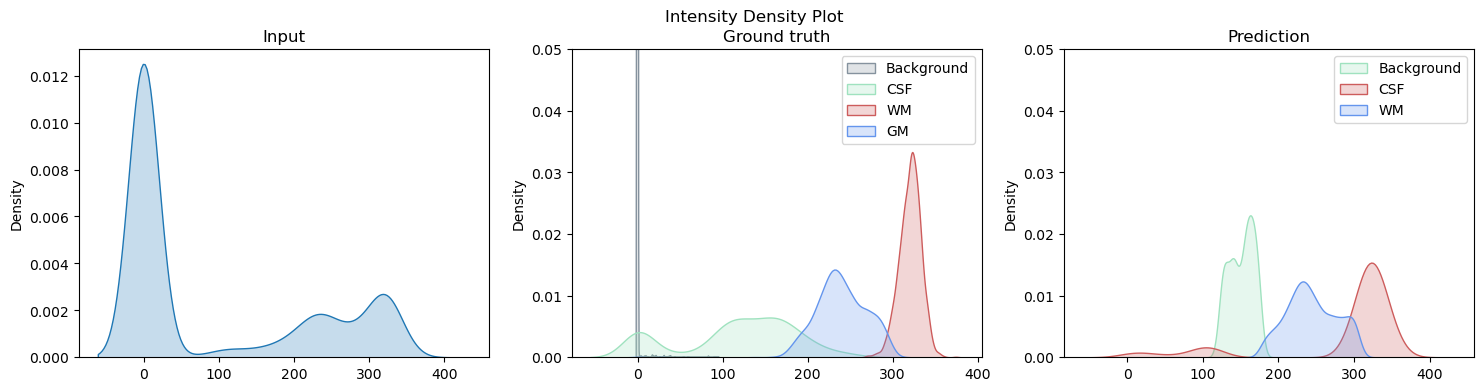

In [21]:
# Plot the obtained results for volume 0 and axial slice 47 of the test set (density estimations)
# --------------------------- ADD YOUR CODE HERE ------------------------------
densityEstimations(pred_seg_2)
# ----------------------------------- END -------------------------------------

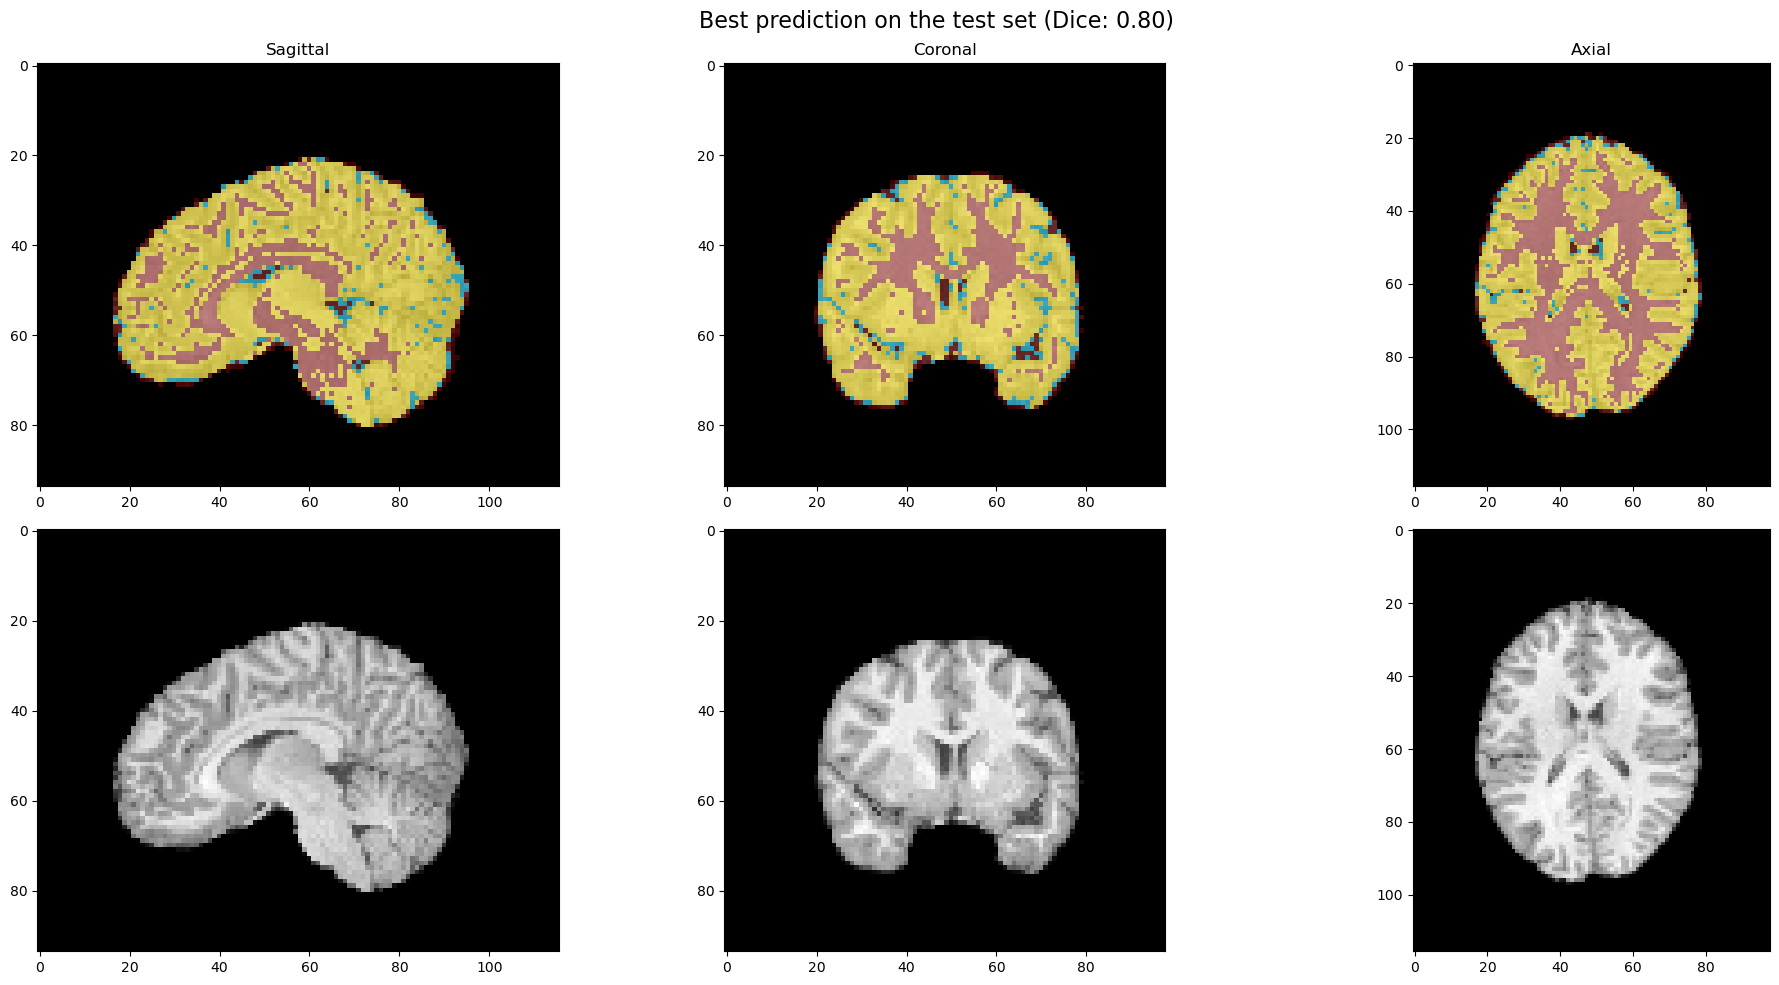

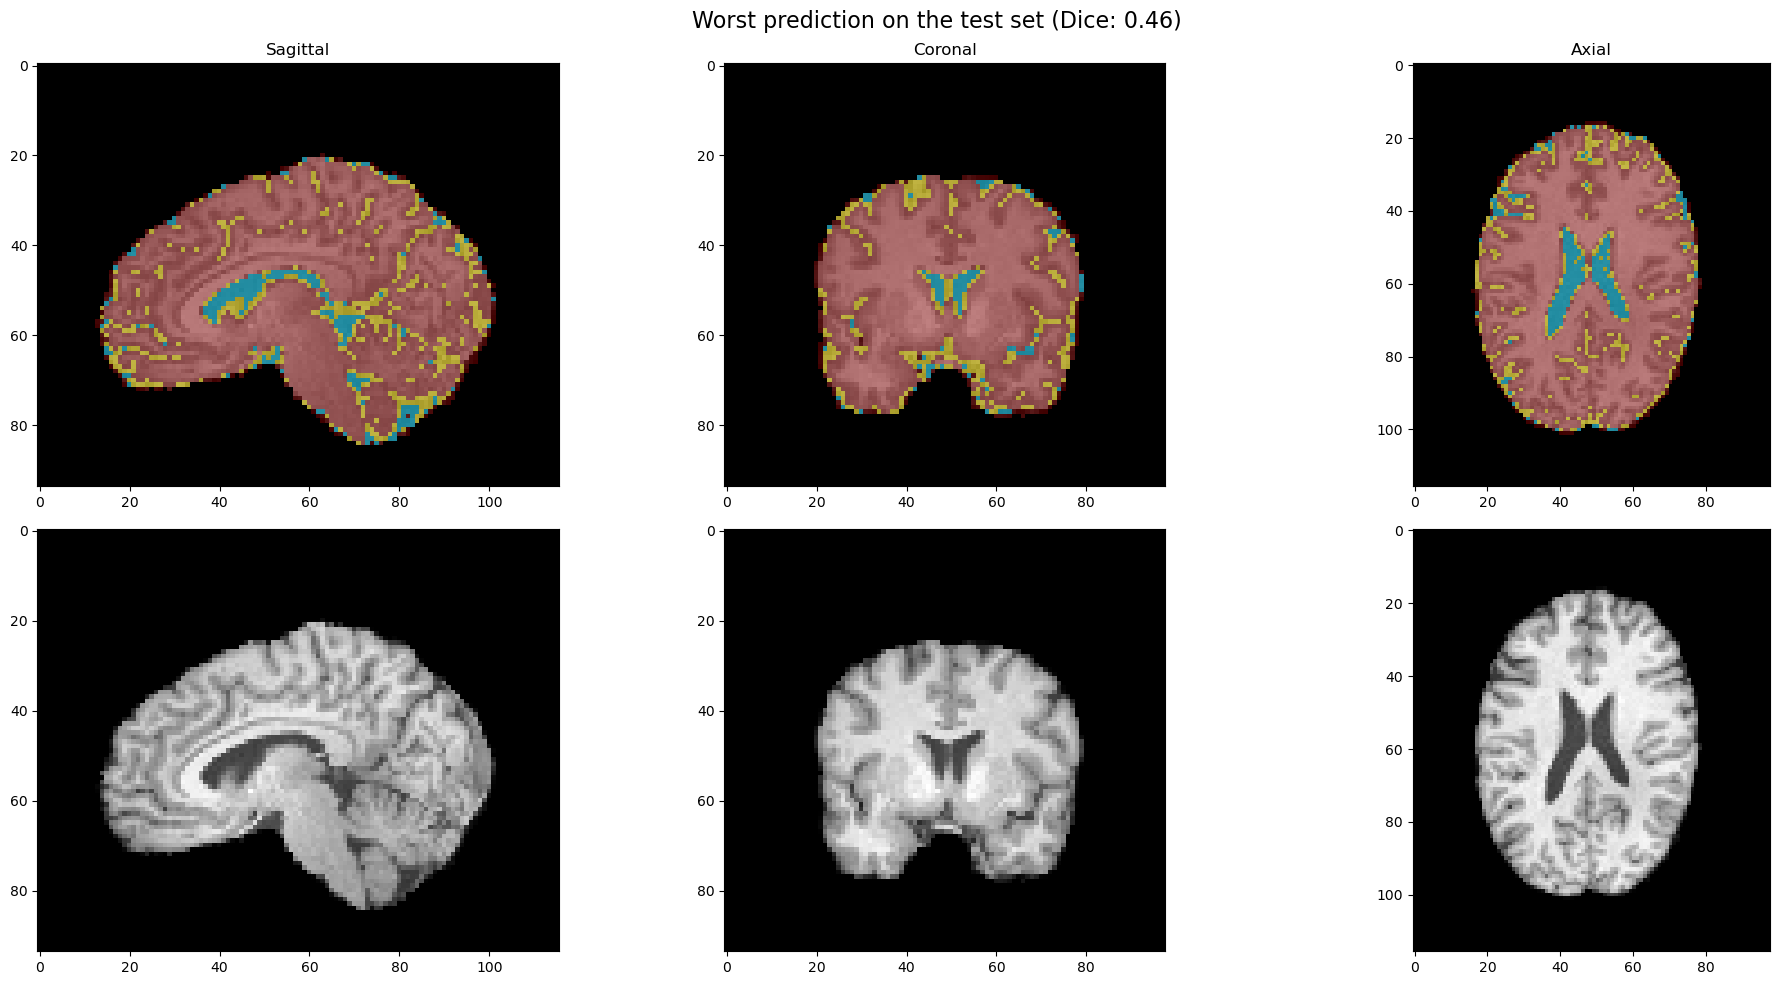

In [22]:
visualize_best_and_worst_samples(pred_seg_2)

# Task 3: Deep supervised segmentation

Deep Learning (DL) methods achieve state-of-the-art results in many (medical) image analyzis applications, including segmentation. Here, you will implement and train a DL method to segment CSF, WM, GM, and background in brain MRI.

First, let's have a look at the individual channels of the segmentations.

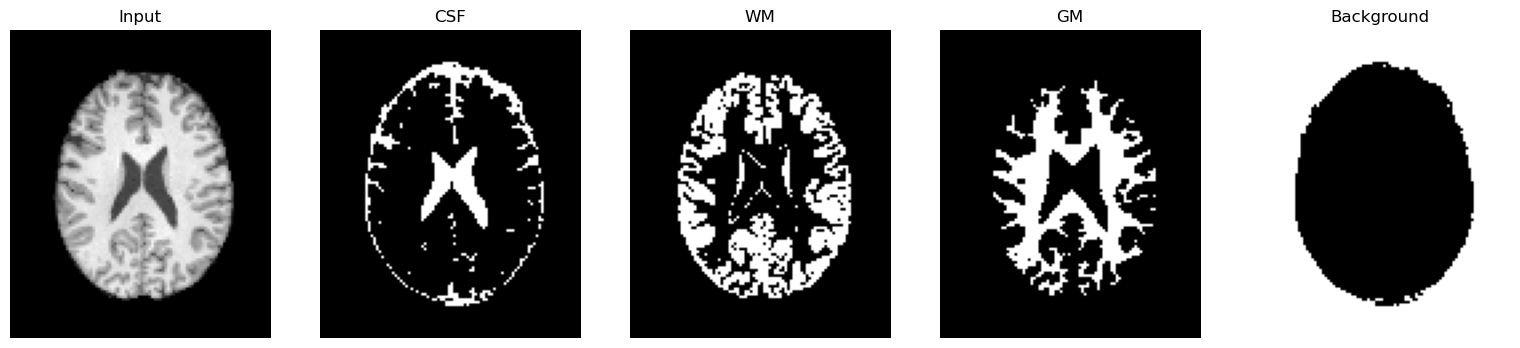

In [33]:
import matplotlib.pyplot as plt
import copy
im = load_nii(val_files[0])
csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[segmentations_val[0]==1] = 1
wm[segmentations_val[0]==2] = 1
gm[segmentations_val[0]==3] = 1
background[segmentations_val[0]==0]=1
elements = [im, csf, wm, gm, background]
titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

## DL-based segmentation

Define and train a U-Net for segmentation (use the train, val, and test splits defined above).

Feel free to choose:
* the number of layers
* the number of features within convolutional layers
* number of convolutions within each layer
* concatenation strategy
* ...

HINT: You can use pre-defined models, e.g., from torchvision, but train them from scratch (no pre-training)

In [34]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm, nibabel]"
%matplotlib inline

In [35]:
from __future__ import annotations

import monai
from monai.apps.utils import download_and_extract
from monai.data import DataLoader, CacheDataset, list_data_collate
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric

from monai.networks.utils import one_hot
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference

import torch
from monai.networks.nets import UNet

root_dir = './model'
model_path =  os.path.join('./model', "new_model.pth")


In [36]:
from skimage.transform import resize
import torch.nn.functional as F
def load_data_from_list_3d(image_files, segmentation_files):
  images = []
  labels = []
  for j in range(int(len(segmentation_files))):
    slice_images = nib.load(image_files[j]).get_fdata()
    slice_labels = segmentation_files[j] 
    slice_images = np.expand_dims(slice_images, axis=0)
    slice_labels = np.expand_dims(slice_labels, axis=0)
    images.append(slice_images)
    labels.append(slice_labels)
  return images, labels

In [ ]:
train_images, train_labels = load_data_from_list_3d(train_files, segmentations_train)
train_img = [{"img": img, "seg": seg} for img, seg in (zip(train_images, train_labels))]
train_ds = CacheDataset(data=train_img,transform=None)
train_loader_3d = DataLoader(train_ds, batch_size=16, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

val_images, val_labels = load_data_from_list_3d(val_files, segmentations_val)
val_img = [{"img": img, "seg": seg} for img, seg in zip(val_images, val_labels)]
val_ds = CacheDataset(data=val_img, transform=None)
val_loader_3d = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

test_images, test_labels = load_data_from_list_3d(test_files, segmentations_test)
test_img = [{"img": img, "seg": seg} for img, seg in zip(test_images, test_labels)]
test_ds = CacheDataset(data=test_img, transform=None)
test_loader_3d = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

Loading dataset:  42%|█████████████████▉                         | 218/522 [00:01<00:01, 204.53it/s]

In [32]:
def train_quicknat3D(model, train_loader, val_loader, view, model_path):
    learning_rate = 1e-3
    print(f"training of {view} UNet")
    best_model = None
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    # optimizer = torch.optim.SGD(
    #     model.parameters(),
    #     lr=learning_rate,
    #     momentum=0.99,
    #     weight_decay=3e-5,
    #     nesterov=True,
    # )
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    max_epochs = 20
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []


    # load pretrained model 
    if os.path.exists(model_path): 
        model.load_state_dict(torch.load(model_path))
        best_model = model.state_dict()
        # Compute the initial validation metric for the pre-loaded model
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["img"].to(device).float(),
                    val_data["seg"].to(device).float(),
                )
                roi_size = (98, 116, 94)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                labels_oneHot = one_hot(val_labels, 4)
                dice_metric(y_pred=val_outputs > 0.5, y=labels_oneHot)

            # aggregate the initial mean dice result
            initial_metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            best_metric = initial_metric
            print(f"Initial mean dice: {initial_metric:.4f}")
    
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["img"].to(device).float(),
                batch_data["seg"].to(device).float(),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["img"].to(device).float(),
                        val_data["seg"].to(device).float(),
                    )
                    roi_size = (98, 116, 94)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                    labels_oneHot = one_hot(val_labels, 4)
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs > 0.5 , y=labels_oneHot)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    best_model = model.state_dict()
                    torch.save(model.state_dict(), model_path)
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
    
    return best_model


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model3d = UNet(spatial_dims = 3,
             in_channels = 1,
             out_channels=4,
             channels=(4, 8, 16, 32),
             strides=(1, 1, 1),
             num_res_units=2) 
model_test = train_quicknat3D(model3d, train_loader_3d, val_loader_3d, "3d", model_path)


training of 3d UNet


In [30]:
import torch.nn.functional as F

def get_prediction(model, test_loader, model_path, device):
    combined_tensors = []
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model = model.to(device)
    new_size = (98, 116, 94)
    for i, batch_data in enumerate(test_loader):
        # Get predictions for image
        pred = model(batch_data["img"].to(device, dtype=torch.float32)).argmax(dim=1)
        current_size = pred.shape[1:]

        # Use interpolate to resize the tensor to the target size
        resized_tensor = F.interpolate(pred.unsqueeze(0).float(), size=new_size, mode='nearest').long().squeeze(0)

        # Append the resized tensor to the list
        combined_tensors.append(resized_tensor.squeeze(0))

    return combined_tensors

In [31]:
# Define and train a neural network (U-Net) for segmentation
# Implement
# --------------------------- ADD YOUR CODE HERE ------------------------------
# pred_seg_3 = get_prediction(model3d, test_loader_3d, os.path.join('./model', "new_model1.pth"), device) # final model from epoch 2
pred_seg_3 = get_prediction(model3d, test_loader_3d, os.path.join('./model', "new_model1.pth"), device) # final model after training 2 epochs + 12 steps
# ----------------------------------- END -------------------------------------

NameError: name 'model3d' is not defined

### Evaluate the Dice scores (separately for every tissue type) for the whole test set.

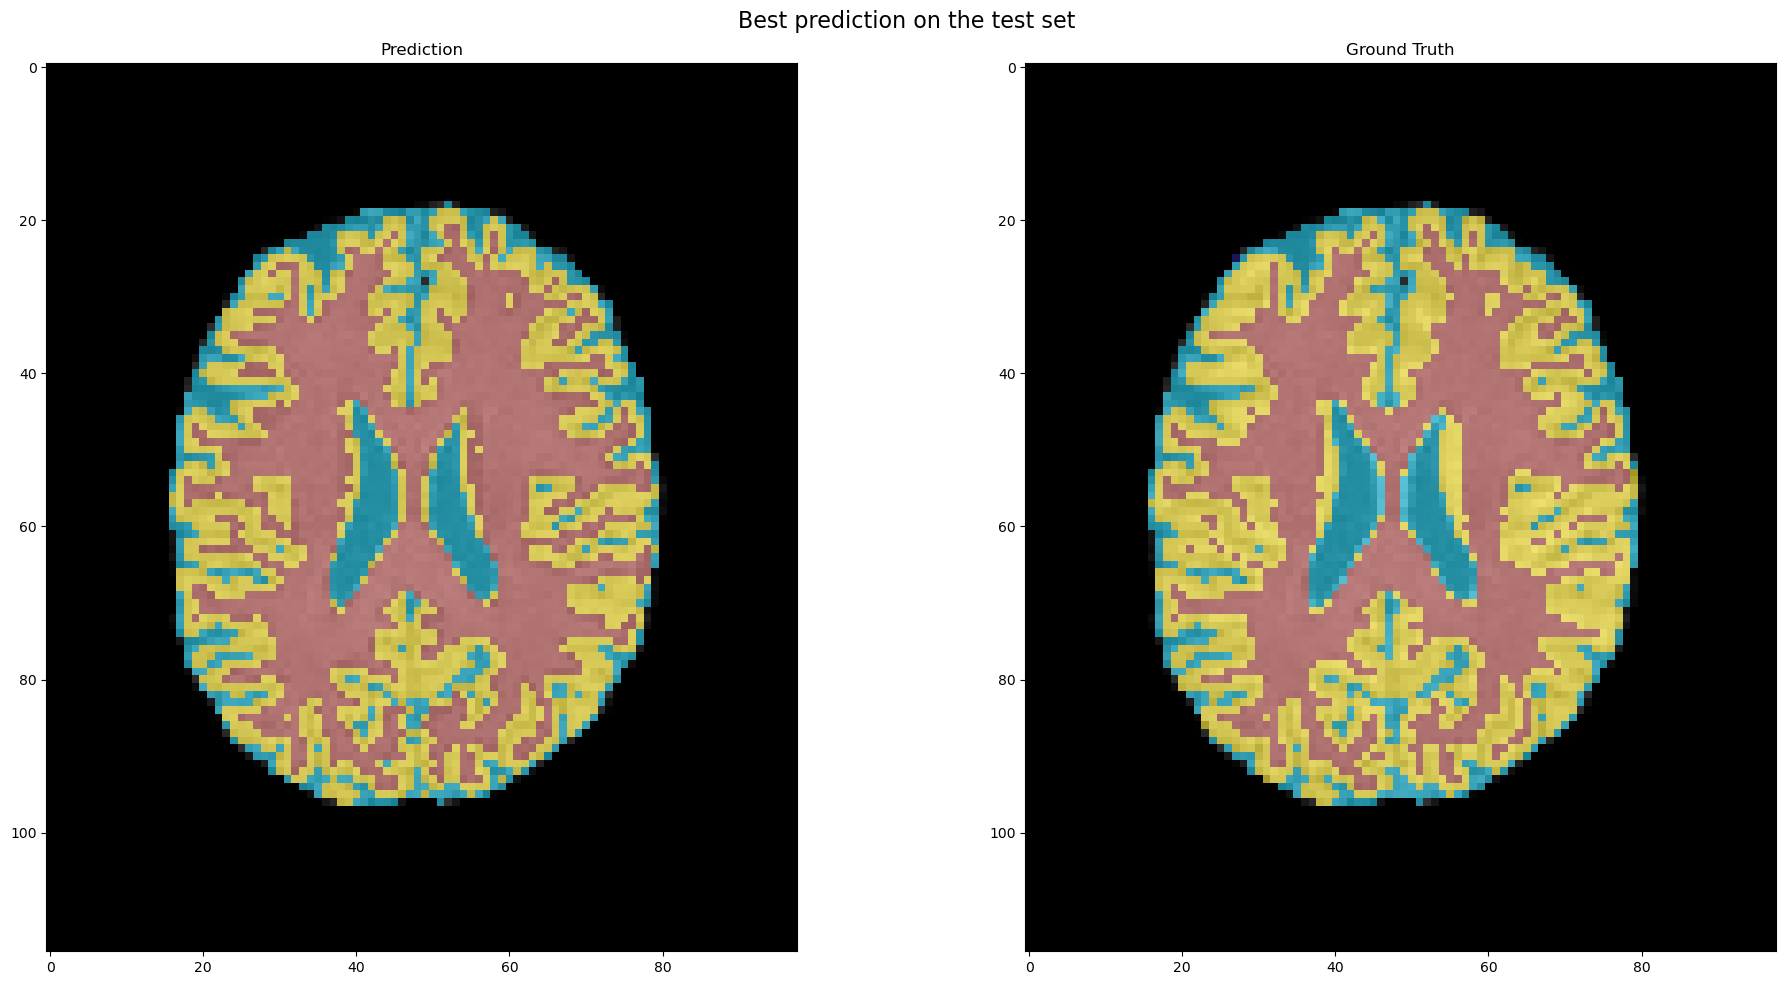

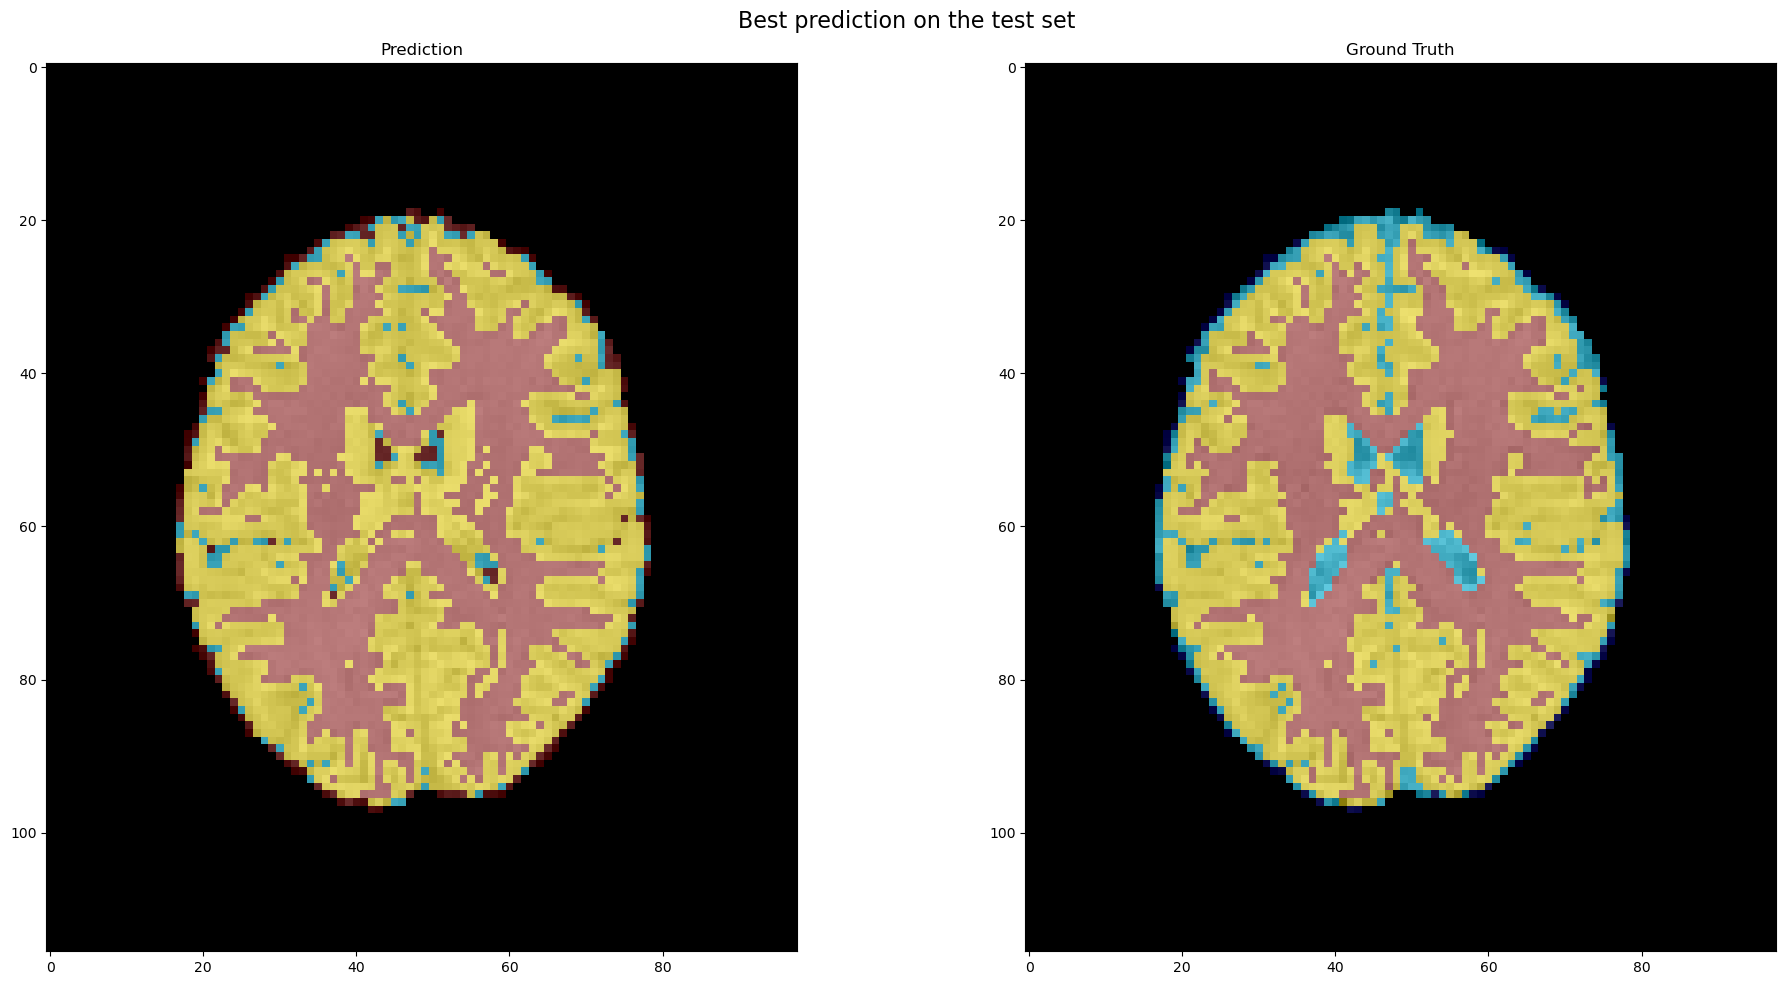

NameError: name 'pred_seg_3' is not defined

In [32]:
# Visualize individual segmentation channels for axial slice 47 of all three approaches and the ground truth in a similar style as above
# Implement
# --------------------------- ADD YOUR CODE HERE ------------------------------
def plot_axial_segmentations(im: np.ndarray, seg: np.ndarray, gt: np.ndarray, i: int = 65, title: str = None):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    ax[0].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0].imshow(np.rot90(seg[..., i], k=3),
                 alpha=0.5 * (np.rot90(seg[..., i] > 0, k=3)),
                 interpolation=None, cmap='jet')
    ax[0].set_title('Prediction')
    ax[1].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[1].imshow(np.rot90(gt[..., i], k=3),
                 alpha=0.5 * (np.rot90(seg[..., i] > 0, k=3)),
                 interpolation=None, cmap='jet')
    ax[1].set_title('Ground Truth')

    if title is not None:
        # plt.set_title(title)
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()

def visualize_best_sample(predictions, i_best=47):
    return_dict = get_best_and_worst_ids(predictions)
    best_id = return_dict['best_id']
    plot_axial_segmentations(load_nii(test_files[best_id]), predictions[best_id], segmentations_test[best_id], i=i_best,
                       title=f'Best prediction on the test set')

visualize_best_sample(pred_seg_1)
visualize_best_sample(pred_seg_2)
visualize_best_sample(pred_seg_3)

plt_seg_1 = None
plt_seg_2 = None
plt_seg_3 = None
plt_gt = None
# ----------------------------------- END -------------------------------------

## Convert the list of PyTorch tensors to a NumPy array
pred_seg_array = np.stack([tensor.cpu().numpy() for tensor in pred_seg_3])

# Save the NumPy array
np.savez('data/brain_age/predictions/pred_seg_3_final.npz', pred_seg_array)

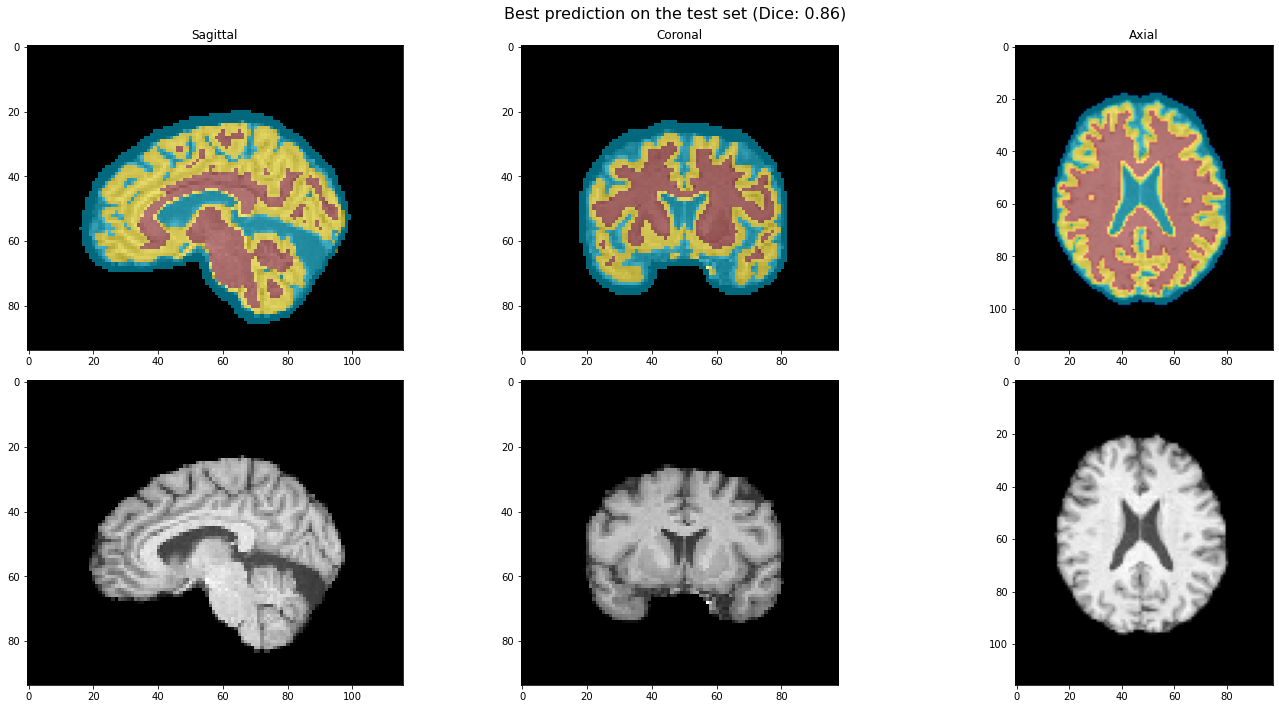

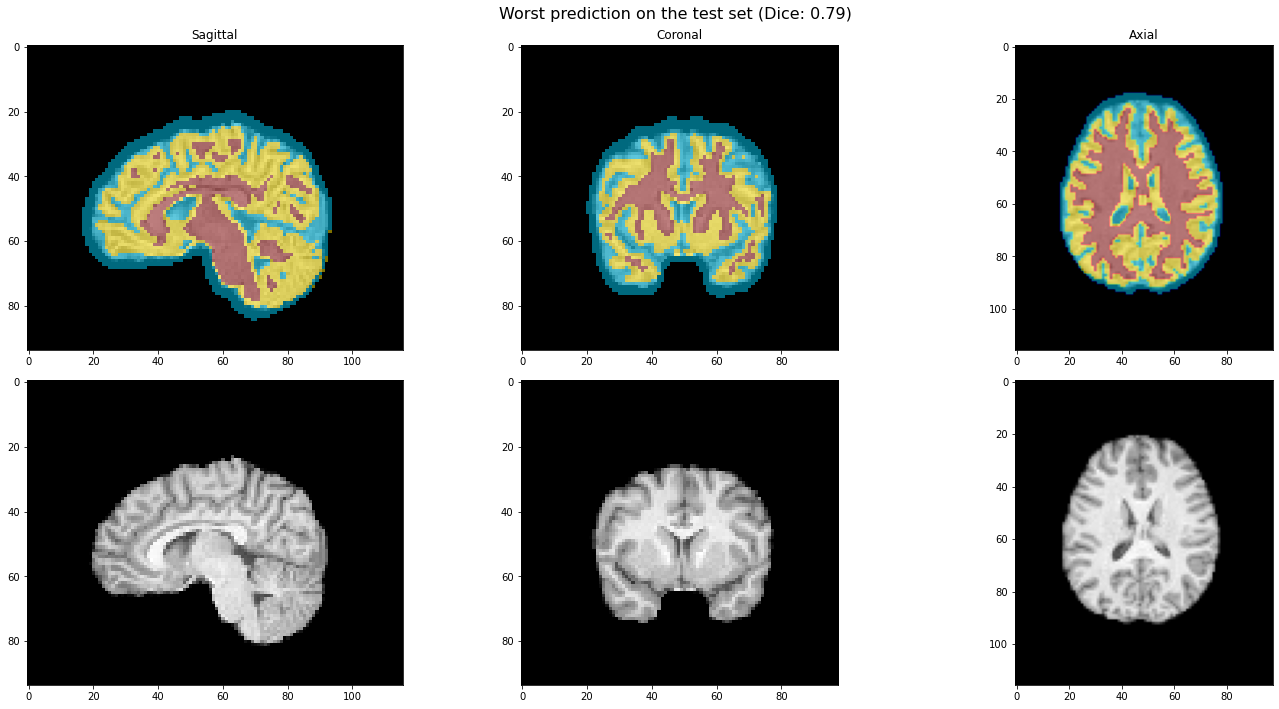

In [32]:
# load prediction: 
# loaded_data = np.load('data/brain_age/predictions/pred_seg_3_final.npz')
# loaded_pred_seg_array = loaded_data['arr_0']
visualize_best_and_worst_samples(pred_seg_3)
# load prediction of model from model after epoch 2 (best: 0.86, worst: 0.73)
# loaded_data = np.load('data/brain_age/predictions/pred_seg_3_final.npz')
# loaded_pred_seg_array = loaded_data['arr_0']
# visualize_best_and_worst_samples(pred_seg_3)

### Summarize the results of all of the segmentation methods implemented.

In [21]:
# Run this block after implementing Q1-3.
results_dictionary = {
    'unsupervised1': get_results_dictionary(pred_seg_1),
    'unsupervised2': get_results_dictionary(pred_seg_2),
    'u-net': get_results_dictionary(pred_seg_3),
}
plot_results_summary(results_dictionary)

NameError: name 'pred_seg_1' is not defined